In [1]:
import numpy
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
import math
import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,  mean_absolute_error, r2_score
 
# tensorflow.reset_default_graph()
tensorflow.random.set_seed(0)
# random.seed(0)
numpy.random.seed(0)

In [2]:
def create_dataset(dataset, look_back=14, day_offset=5):
    dataX, dataY= [],[]
    dataX=numpy.zeros([(len(dataset)-look_back),6,look_back])
    
    #print(dataX.shape)
    for i in range(look_back,len(dataset)):
       # print(i)
        a = numpy.zeros([6,look_back])
        t1=dataset[(i-look_back):i, 0]
        t1=numpy.reshape(t1,[1,look_back])
        t4=dataset[(i-look_back):i, 48]
        t4=numpy.reshape(t4,[1,look_back])
        #print(t1.shape)
        t2=dataset[i, 48-look_back:48]
        t2=numpy.reshape(t2,[1,look_back])
        t6=dataset[i,-(look_back+3):-3]
        t6=numpy.reshape(t6,[1,look_back])
        t3=numpy.zeros([1,look_back])
        if i>=((day_offset+1)*7+look_back):
            t3[0,0:day_offset]=[dataset[j,0] for j in range(i-(((day_offset+1)*7)+look_back),i-(look_back+7),7)]
        t5=numpy.zeros([1,look_back])
        if i>=((day_offset+1)*7+look_back):
            t5[0,0:day_offset]=[dataset[j,48] for j in range(i-(((day_offset+1)*7)+look_back),i-(look_back+7),7)]
            
            
        #print(t2.shape)
        a[0,:] = t1
        a[1,:] = t4
        a[2,:] = t2
        a[3,:] = t6
        a[4,:] = t3
        a[5,:] = t5
        dataX[i-look_back,:,:]=a
#         a = numpy.concatenate([dataset[(i-look_back-7):i-7, 0], dataset[i,-14:]],axis=1)
        
        #dataX.append(a)
        dataY.append(dataset[i,-1])
    return numpy.array(dataX), numpy.array(dataY)

In [3]:
def missing_values(datarange, categorical=[]):  
    datarange= pd.DataFrame(datarange)
    if not categorical:
        meandata=datarange.mean()
        meandata=meandata.to_numpy()
    else:
        meandata=datarange.mean()
        meandata=meandata.to_numpy()
        
        modedata = datarange.mode()
        modedata = modedata.to_numpy()
        modedata = modedata[0,:]
        
        for i in categorical:
                meandata[i-1] = modedata[i]
                
    datetime_series = pd.to_datetime(datarange['fltdat'])
    miss_idx=pd.date_range(start = '01-01-2015', end = '31-12-2019' ).difference(datetime_series)
    datetime_index = pd.DatetimeIndex(datetime_series.values)
    datarange=datarange.set_index(datetime_index)

    datarange.drop('fltdat',axis=1,inplace=True)
    newidx = pd.date_range('01-01-2015', '31-12-2019')
    datarange = datarange.reindex(newidx, fill_value=0)
    
    meandata=meandata.reshape(1,meandata.shape[0])
    dat = numpy.tile(meandata, [miss_idx.shape[0],1])
    datarange.loc[miss_idx]=dat
    return datarange

In [4]:
def mean_absolute_percentage_error(y_test, y_pred):
        import numpy as np
        t = np.array(y_test)
        p = np.array(y_pred)
        mae = list()
        mape = list()
        for i in range(len(t)):
            if (t[i] == 0):
                mae.append(abs(p[i]))
            else:
                mae.append(float(abs(t[i] - p[i])))
                mape.append(float(abs((t[i] - p[i])/t[i])))
        return np.mean(mae) , np.mean(mape)

In [5]:
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('data/rmscapfc.csv', parse_dates=['fltdat'],dayfirst=True)
print(dataframe.columns)
dataframe.drop(dataframe.columns[[2,3,4,6,8,9,10,56,57,58,59,60,61,62] ], axis=1, inplace=True)

dataframe2 = read_csv('data/rmscapy.csv', parse_dates=['fltdat'],dayfirst=True)
# print(dataframe2.columns)
f_column = dataframe2[["paxcnty", "dcp_51", "dcp_50", "dcp_49", "dcp_48", "dcp_47", "dcp_46",
       "dcp_45", "dcp_44", "dcp_43", "dcp_42", "dcp_41", "dcp_40", "dcp_39",
       "dcp_38", "dcp_37", "dcp_36", "dcp_35", "dcp_34", "dcp_33", "dcp_3",
       "dcp_31", "dcp_30", "dcp_29", "dcp_28", "dcp_27", "dcp_26", "dcp_25",
       "dcp_24", "dcp_23", "dcp_22", "dcp_21", "dcp_20", "dcp_19", "dcp_18",
       "dcp_17", "dcp_16", "dcp_15", "dcp_14", "dcp_13", "dcp_12", "dcp_11",
       "dcp_10", "dcp_9", "dcp_8"]]
 

dataframe = pd.concat([dataframe,f_column], axis = 1)
# print(dataframe.columns)
dataframe3 = read_csv('data/uldfc.csv', parse_dates=['fltdat'],dayfirst=True)

dataframe3.drop(dataframe3.columns[[1,2,3] ], axis=1, inplace=True)
dataframe4 = read_csv('data/uldy.csv', parse_dates=['fltdat'],dayfirst=True)
dataframe4.drop(dataframe4.columns[[1,2,3] ], axis=1, inplace=True)
f_column = dataframe4[["county"]]
dataframe3 = pd.concat([dataframe3,f_column], axis = 1)
print(dataframe.columns)

Index(['fltdat', 'paxcntfc', 'fltnum', 'legorg', 'legdst', 'acrtypcod',
       'keyidr', 'totpaylodwgt', 'totpaylodvol', 'totpaylodpos', 'totsetfc',
       'totpaxwgt', 'dp_51', 'dp_50', 'dp_49', 'dp_48', 'dp_47', 'dp_46',
       'dp_45', 'dp_44', 'dp_43', 'dp_42', 'dp_41', 'dp_40', 'dp_39', 'dp_38',
       'dp_37', 'dp_36', 'dp_35', 'dp_34', 'dp_33', 'dp_32', 'dp_31', 'dp_30',
       'dp_29', 'dp_28', 'dp_27', 'dp_26', 'dp_25', 'dp_24', 'dp_23', 'dp_22',
       'dp_21', 'dp_20', 'dp_19', 'dp_18', 'dp_17', 'dp_16', 'dp_15', 'dp_14',
       'dp_13', 'dp_12', 'dp_11', 'dp_10', 'dp_9', 'dp_8', 'dp_7', 'dp_6',
       'dp_5', 'dp_4', 'dp_3', 'dp_2', 'dp_1'],
      dtype='object')
Index(['fltdat', 'paxcntfc', 'acrtypcod', 'totpaylodwgt', 'totpaxwgt', 'dp_51',
       'dp_50', 'dp_49', 'dp_48', 'dp_47', 'dp_46', 'dp_45', 'dp_44', 'dp_43',
       'dp_42', 'dp_41', 'dp_40', 'dp_39', 'dp_38', 'dp_37', 'dp_36', 'dp_35',
       'dp_34', 'dp_33', 'dp_32', 'dp_31', 'dp_30', 'dp_29', 'dp_28', 'dp_27',

In [6]:
NUM=[0,1825,1825,1817,1816,1812,1821,1825,1824,1819,1825,1825,1824,1826,1819,1825,1822,1823,1813, 1826, 1820]
NUMuld=[0,1817,1574,1808,1802,1807,1808,1730,1817,1385,1820,1816,1606,1819,1810,1817,421,1813,434,1532,1814]
cat_inp=[2]

In [7]:
# dataset, datasetY = numpy.empty([1805,3,look_back]), []
for i in range(0,len(NUM)-1):
#     print(i)
    datasub = dataframe.iloc[sum(NUM[0:i+1]):sum(NUM[0:i+2]),:]
#     datasub=datasetall[sum(NUM[0:i+1]):sum(NUM[0:i+2]),:]
    datasub = missing_values(datasub, cat_inp)
    datasub = datasub.values
    datasub = datasub.astype('float32')
    
    datasubuld = dataframe3.iloc[sum(NUMuld[0:i+1]):sum(NUMuld[0:i+2]),:]
#     datasub=datasetall[sum(NUM[0:i+1]):sum(NUM[0:i+2]),:]
    datasubuld = missing_values(datasubuld)
    datasubuld = datasubuld.values
    datasubuld = datasubuld.astype('float32')
    
    datasub = numpy.concatenate([datasub, datasubuld], axis=1)
    if i==0:
        data = datasub
    else:
        data = numpy.concatenate([data, datasub], axis =0)
 

C:\Users\iist\anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  import sys
C:\Users\iist\anaconda3\envs\tf-gpu-cuda8\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  after removing the cwd from sys.path.


In [8]:
out = data[:,2] - data[:,3] - (data[:,-1]*data[:,-2]*114)
out = out.reshape(out.shape[0],1)
data = numpy.concatenate([data,out], axis=1)
print(data.shape)

(36520, 96)


In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(data)

In [10]:
def sequence_data_build(data, look_back):
    for i in range(0,20):
        datasub = data[i*1826:((i+1)*1826),:]
        X, Y = create_dataset(datasub, look_back)
        Y = Y.reshape(Y.shape[0],1)
        if i==0: 
            data_LSTM_X = X
            data_LSTM_Y = Y
        else:
            data_LSTM_X = numpy.concatenate([data_LSTM_X, X],axis=0)
            data_LSTM_Y = numpy.concatenate([data_LSTM_Y, Y],axis=0)
    return data_LSTM_X, data_LSTM_Y

In [11]:
def train_test_build(X, Y, m1, m2):
    spliter=int(X.shape[0]/20)
    tot_len = m1
    train_len = m2
    for i in range(0,20):
        Xsub = X[i*spliter:((i+1)*spliter),:]
        Ysub = Y[i*spliter:((i+1)*spliter)]
        if i==0:
            trainX = Xsub[0:m2,:]
            testX = Xsub[m2:m1,:]
            trainY = Ysub[0:m2]
            testY = Ysub[m2:m1]
        else:
            trainX = numpy.concatenate([trainX, Xsub[0:m2,:]], axis=0)
            testX = numpy.concatenate([testX, Xsub[m2:m1,:]], axis=0)
            trainY = numpy.concatenate([trainY, Ysub[0:m2]], axis=0)
            testY = numpy.concatenate([testY, Ysub[m2:m1]], axis=0)
        
    return trainX, trainY, testX, testY

In [12]:
def model_build(trainX, trainY, testX, testY, units, saving =False, month=None, EarlyStop = False):
    
    if EarlyStop:
        callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                                            mode = 'min', restore_best_weights=True)
                                                                    
    model = Sequential()
    model.add(LSTM(units, input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    if EarlyStop:
        history = model.fit(trainX, trainY, epochs=100, batch_size=150, validation_data=(testX, testY),verbose=1,
                            callbacks=[callback])
    else:
        history = model.fit(trainX, trainY, epochs=100, batch_size=150, validation_data=(testX, testY),verbose=1, )#callbacks=[callback]
        
                
    testPredict = model.predict(testX)
                
    sh = testPredict.shape
    inv_yhat = testPredict.reshape(sh[0]*sh[1],1)
    inv_yhat = numpy.concatenate([ data[0:inv_yhat.shape[0],0:95], inv_yhat], axis=1)

    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]
    testY = testY.reshape(sh[0]*sh[1],1)
 
    inv_y = numpy.concatenate([data[0:testY.shape[0],0:95], testY], axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,-1]
             
    rmse = numpy.sqrt(mean_squared_error(inv_y, inv_yhat))
    mae, mape = mean_absolute_percentage_error(inv_y, inv_yhat) 
    r2 = r2_score(inv_y, inv_yhat)
    
    res=[]
    if saving:
        inv_y = inv_y.reshape(inv_y.shape[0],1) 
        inv_yhat = inv_yhat.reshape(inv_yhat.shape[0],1) 
        res = numpy.concatenate([inv_y, inv_yhat], axis=1)
        df = pd.DataFrame(res)
        res = df.to_csv("ds_" + month + ".csv", index = False)
    return rmse, mape,mae,r2, history

In [15]:
def cross_validation(lag_vec = [7,14,21,28], units_vec = [2,4,8,16,32,64,128]):
    results = numpy.zeros([4,3,len(lag_vec),len(units_vec)]) 
    for folds in range(0,3):
        for i in range(0,len(lag_vec)):
            data_LSTM_X, data_LSTM_Y = sequence_data_build(data, lag_vec[i])
            lag = lag_vec[i]
            totday = int(data_LSTM_X.shape[0]/20)
#             print(totday)
            m1 = [totday-152, totday-121, totday-91, ]
            m2 = [m1[0]-31, m1[1]-31, m1[2]-30, ]
            trainX, trainY, testX, testY= train_test_build(data_LSTM_X, data_LSTM_Y, m1[folds], m2[folds])
            
            testYcopy=testY
            for j in range(0, len(units_vec)):
                print(" ")
                print(" ")
                print(" ")
                print("------------------------------------------------")
                print("fold: {0}, lag: {1}, units: {2}".format(folds, lag_vec[i], units_vec[j]))
                units = units_vec[j]
                rmse, mape, mae, r2, his = model_build(trainX, trainY, testX, testY, units, EarlyStop=True) 
                results[0,folds,i,j] = rmse 
                results[2,folds,i,j], results[1,folds,i,j] = mae, mape
                results[3,folds,i,j] = r2
    return results        

In [17]:
lag_vec = [7,14,]
units_vec = [2,4,8,16,32,64,128]
results = cross_validation(lag_vec, units_vec)


 
 
 
------------------------------------------------
fold: 0, lag: 7, units: 2
Train on 32720 samples, validate on 620 samples
Epoch 1/100
32720/32720 [==============================] - 5s 166us/sample - loss: 0.1922 - val_loss: 0.1474
Epoch 2/100
32720/32720 [==============================] - 2s 58us/sample - loss: 0.1596 - val_loss: 0.1108
Epoch 3/100
32720/32720 [==============================] - 2s 59us/sample - loss: 0.1445 - val_loss: 0.1072
Epoch 4/100
32720/32720 [==============================] - 2s 57us/sample - loss: 0.1392 - val_loss: 0.1094
Epoch 5/100
32720/32720 [==============================] - 2s 59us/sample - loss: 0.1358 - val_loss: 0.1023
Epoch 6/100
32720/32720 [==============================] - 2s 57us/sample - loss: 0.1330 - val_loss: 0.1056
Epoch 7/100
32720/32720 [==============================] - 2s 59us/sample - loss: 0.1311 - val_loss: 0.0984
Epoch 8/100
32720/32720 [==============================] - 2s 58us/sample - loss: 0.1295 - val_loss: 0.1001
Epoch 

Epoch 27/100
32720/32720 [==============================] - 2s 57us/sample - loss: 0.1061 - val_loss: 0.0812
Epoch 28/100
32720/32720 [==============================] - 2s 51us/sample - loss: 0.1056 - val_loss: 0.0854
Epoch 29/100
32720/32720 [==============================] - 2s 61us/sample - loss: 0.1048 - val_loss: 0.0808
Epoch 30/100
32720/32720 [==============================] - 2s 59us/sample - loss: 0.1042 - val_loss: 0.0830
Epoch 31/100
32720/32720 [==============================] - 2s 61us/sample - loss: 0.1036 - val_loss: 0.0787
Epoch 32/100
32720/32720 [==============================] - 2s 60us/sample - loss: 0.1032 - val_loss: 0.0774
Epoch 33/100
32720/32720 [==============================] - 2s 64us/sample - loss: 0.1028 - val_loss: 0.0772
Epoch 34/100
32720/32720 [==============================] - 2s 61us/sample - loss: 0.1023 - val_loss: 0.0758
Epoch 35/100
32720/32720 [==============================] - 2s 64us/sample - loss: 0.1021 - val_loss: 0.0755
Epoch 36/100
32720/

32720/32720 [==============================] - 2s 58us/sample - loss: 0.1044 - val_loss: 0.0738
Epoch 23/100
32720/32720 [==============================] - 2s 56us/sample - loss: 0.1043 - val_loss: 0.0724
Epoch 24/100
32720/32720 [==============================] - 2s 56us/sample - loss: 0.1036 - val_loss: 0.0726
Epoch 25/100
32720/32720 [==============================] - 2s 60us/sample - loss: 0.1032 - val_loss: 0.0743
Epoch 26/100
32720/32720 [==============================] - 2s 56us/sample - loss: 0.1030 - val_loss: 0.0719
Epoch 27/100
32720/32720 [==============================] - 2s 57us/sample - loss: 0.1025 - val_loss: 0.0707
Epoch 28/100
32720/32720 [==============================] - 2s 58us/sample - loss: 0.1023 - val_loss: 0.0793
Epoch 29/100
32720/32720 [==============================] - 2s 59us/sample - loss: 0.1021 - val_loss: 0.0713
Epoch 30/100
32720/32720 [==============================] - 2s 60us/sample - loss: 0.1017 - val_loss: 0.0750
Epoch 31/100
32720/32720 [======

32720/32720 [==============================] - 2s 57us/sample - loss: 0.1018 - val_loss: 0.0720
Epoch 18/100
32720/32720 [==============================] - 2s 58us/sample - loss: 0.1015 - val_loss: 0.0711
Epoch 19/100
32720/32720 [==============================] - 2s 59us/sample - loss: 0.1007 - val_loss: 0.0700
Epoch 20/100
32720/32720 [==============================] - 2s 59us/sample - loss: 0.1003 - val_loss: 0.0679
Epoch 21/100
32720/32720 [==============================] - 2s 57us/sample - loss: 0.1000 - val_loss: 0.0693
Epoch 22/100
32720/32720 [==============================] - 2s 64us/sample - loss: 0.0996 - val_loss: 0.0678
Epoch 23/100
32720/32720 [==============================] - 2s 64us/sample - loss: 0.0991 - val_loss: 0.0666
Epoch 24/100
32720/32720 [==============================] - 2s 60us/sample - loss: 0.0986 - val_loss: 0.0663
Epoch 25/100
32720/32720 [==============================] - 2s 58us/sample - loss: 0.0988 - val_loss: 0.0644
Epoch 26/100
32720/32720 [======

32720/32720 [==============================] - 2s 59us/sample - loss: 0.0973 - val_loss: 0.0710
Epoch 29/100
32720/32720 [==============================] - 2s 58us/sample - loss: 0.0974 - val_loss: 0.0663
Epoch 30/100
32720/32720 [==============================] - 2s 58us/sample - loss: 0.0967 - val_loss: 0.0665
Epoch 31/100
32720/32720 [==============================] - 2s 57us/sample - loss: 0.0960 - val_loss: 0.0643
Epoch 32/100
32720/32720 [==============================] - 2s 58us/sample - loss: 0.0961 - val_loss: 0.0645
Epoch 33/100
32720/32720 [==============================] - 2s 58us/sample - loss: 0.0954 - val_loss: 0.0625
Epoch 34/100
32720/32720 [==============================] - 2s 59us/sample - loss: 0.0950 - val_loss: 0.0616
Epoch 35/100
32720/32720 [==============================] - 2s 58us/sample - loss: 0.0947 - val_loss: 0.0631
Epoch 36/100
32720/32720 [==============================] - 2s 58us/sample - loss: 0.0946 - val_loss: 0.0610
Epoch 37/100
32720/32720 [======

32720/32720 [==============================] - 2s 71us/sample - loss: 0.0902 - val_loss: 0.0554
Epoch 47/100
32720/32720 [==============================] - 2s 70us/sample - loss: 0.0901 - val_loss: 0.0569
Epoch 48/100
32720/32720 [==============================] - 2s 70us/sample - loss: 0.0898 - val_loss: 0.0562
Epoch 49/100
32720/32720 [==============================] - 2s 70us/sample - loss: 0.0899 - val_loss: 0.0561
Epoch 50/100
32720/32720 [==============================] - 2s 72us/sample - loss: 0.0892 - val_loss: 0.0553
Epoch 51/100
32720/32720 [==============================] - 2s 72us/sample - loss: 0.0892 - val_loss: 0.0563
Epoch 52/100
32720/32720 [==============================] - 2s 73us/sample - loss: 0.0894 - val_loss: 0.0575
Epoch 53/100
32720/32720 [==============================] - 2s 72us/sample - loss: 0.0889 - val_loss: 0.0561
Epoch 54/100
32720/32720 [==============================] - 2s 70us/sample - loss: 0.0888 - val_loss: 0.0573
Epoch 55/100
32720/32720 [======

Epoch 35/100
32720/32720 [==============================] - 4s 115us/sample - loss: 0.0902 - val_loss: 0.0571
Epoch 36/100
32720/32720 [==============================] - 4s 114us/sample - loss: 0.0901 - val_loss: 0.0579
Epoch 37/100
32720/32720 [==============================] - 4s 115us/sample - loss: 0.0896 - val_loss: 0.0570
Epoch 38/100
32720/32720 [==============================] - 4s 113us/sample - loss: 0.0897 - val_loss: 0.0585
Epoch 39/100
32720/32720 [==============================] - 4s 114us/sample - loss: 0.0894 - val_loss: 0.0569
Epoch 40/100
32720/32720 [==============================] - 4s 114us/sample - loss: 0.0891 - val_loss: 0.0556
Epoch 41/100
32720/32720 [==============================] - 4s 115us/sample - loss: 0.0890 - val_loss: 0.0572
Epoch 42/100
32720/32720 [==============================] - 4s 114us/sample - loss: 0.0887 - val_loss: 0.0594
Epoch 43/100
32720/32720 [==============================] - 4s 114us/sample - loss: 0.0887 - val_loss: 0.0565
Epoch 44/1

32580/32580 [==============================] - 2s 58us/sample - loss: 0.1184 - val_loss: 0.0948
Epoch 11/100
32580/32580 [==============================] - 2s 56us/sample - loss: 0.1169 - val_loss: 0.0880
Epoch 12/100
32580/32580 [==============================] - 2s 57us/sample - loss: 0.1157 - val_loss: 0.0873
Epoch 13/100
32580/32580 [==============================] - 2s 56us/sample - loss: 0.1152 - val_loss: 0.0820
Epoch 14/100
32580/32580 [==============================] - 2s 63us/sample - loss: 0.1139 - val_loss: 0.0863
Epoch 15/100
32580/32580 [==============================] - 2s 63us/sample - loss: 0.1128 - val_loss: 0.0886
Epoch 16/100
32580/32580 [==============================] - 2s 59us/sample - loss: 0.1119 - val_loss: 0.0822
Epoch 17/100
32580/32580 [==============================] - 2s 62us/sample - loss: 0.1111 - val_loss: 0.0856
Epoch 18/100
32580/32580 [==============================] - 2s 61us/sample - loss: 0.1099 - val_loss: 0.0823
Epoch 19/100
32580/32580 [======

32580/32580 [==============================] - 2s 56us/sample - loss: 0.1172 - val_loss: 0.0852
Epoch 7/100
32580/32580 [==============================] - 2s 56us/sample - loss: 0.1153 - val_loss: 0.0875
Epoch 8/100
32580/32580 [==============================] - 2s 61us/sample - loss: 0.1136 - val_loss: 0.0814
Epoch 9/100
32580/32580 [==============================] - 2s 58us/sample - loss: 0.1121 - val_loss: 0.0828
Epoch 10/100
32580/32580 [==============================] - 2s 61us/sample - loss: 0.1110 - val_loss: 0.0798
Epoch 11/100
32580/32580 [==============================] - 2s 58us/sample - loss: 0.1091 - val_loss: 0.0818
Epoch 12/100
32580/32580 [==============================] - 2s 53us/sample - loss: 0.1078 - val_loss: 0.0772
Epoch 13/100
32580/32580 [==============================] - 2s 55us/sample - loss: 0.1066 - val_loss: 0.0736
Epoch 14/100
32580/32580 [==============================] - 2s 51us/sample - loss: 0.1053 - val_loss: 0.0733
Epoch 15/100
32580/32580 [=========

32580/32580 [==============================] - 2s 59us/sample - loss: 0.0957 - val_loss: 0.0654
Epoch 25/100
32580/32580 [==============================] - 2s 59us/sample - loss: 0.0960 - val_loss: 0.0645
Epoch 26/100
32580/32580 [==============================] - 2s 57us/sample - loss: 0.0955 - val_loss: 0.0635
Epoch 27/100
32580/32580 [==============================] - 2s 56us/sample - loss: 0.0953 - val_loss: 0.0640
Epoch 28/100
32580/32580 [==============================] - 2s 57us/sample - loss: 0.0951 - val_loss: 0.0649
Epoch 29/100
32580/32580 [==============================] - 2s 58us/sample - loss: 0.0947 - val_loss: 0.0620
Epoch 30/100
32580/32580 [==============================] - 2s 57us/sample - loss: 0.0944 - val_loss: 0.0641
Epoch 31/100
32580/32580 [==============================] - 2s 57us/sample - loss: 0.0942 - val_loss: 0.0630
Epoch 32/100
32580/32580 [==============================] - 2s 58us/sample - loss: 0.0943 - val_loss: 0.0645
Epoch 33/100
32580/32580 [======

32580/32580 [==============================] - 2s 59us/sample - loss: 0.0921 - val_loss: 0.0651
Epoch 36/100
32580/32580 [==============================] - 2s 61us/sample - loss: 0.0920 - val_loss: 0.0604
Epoch 37/100
32580/32580 [==============================] - 2s 61us/sample - loss: 0.0919 - val_loss: 0.0630
Epoch 38/100
32580/32580 [==============================] - 2s 60us/sample - loss: 0.0914 - val_loss: 0.0600
Epoch 39/100
32580/32580 [==============================] - 2s 59us/sample - loss: 0.0921 - val_loss: 0.0626
Epoch 40/100
32580/32580 [==============================] - 2s 58us/sample - loss: 0.0910 - val_loss: 0.0609
Epoch 41/100
32580/32580 [==============================] - 2s 60us/sample - loss: 0.0906 - val_loss: 0.0602
Epoch 42/100
32580/32580 [==============================] - 2s 54us/sample - loss: 0.0903 - val_loss: 0.0614
Epoch 43/100
32580/32580 [==============================] - 2s 58us/sample - loss: 0.0901 - val_loss: 0.0634
Epoch 44/100
32580/32580 [======

32580/32580 [==============================] - 2s 73us/sample - loss: 0.0943 - val_loss: 0.0641
Epoch 22/100
32580/32580 [==============================] - 2s 72us/sample - loss: 0.0945 - val_loss: 0.0653
Epoch 23/100
32580/32580 [==============================] - 2s 76us/sample - loss: 0.0939 - val_loss: 0.0654
Epoch 24/100
32580/32580 [==============================] - 2s 70us/sample - loss: 0.0930 - val_loss: 0.0616
Epoch 25/100
32580/32580 [==============================] - 2s 72us/sample - loss: 0.0923 - val_loss: 0.0622
Epoch 26/100
32580/32580 [==============================] - 2s 73us/sample - loss: 0.0924 - val_loss: 0.0655
Epoch 27/100
32580/32580 [==============================] - 2s 71us/sample - loss: 0.0920 - val_loss: 0.0645
Epoch 28/100
32580/32580 [==============================] - 2s 72us/sample - loss: 0.0913 - val_loss: 0.0643
Epoch 29/100
32580/32580 [==============================] - 2s 73us/sample - loss: 0.0911 - val_loss: 0.0618
Epoch 30/100
32580/32580 [======

32580/32580 [==============================] - 4s 108us/sample - loss: 0.0852 - val_loss: 0.0539
Epoch 37/100
32580/32580 [==============================] - 4s 110us/sample - loss: 0.0847 - val_loss: 0.0571
Epoch 38/100
32580/32580 [==============================] - 4s 110us/sample - loss: 0.0849 - val_loss: 0.0531
Epoch 39/100
32580/32580 [==============================] - 4s 108us/sample - loss: 0.0847 - val_loss: 0.0545
Epoch 40/100
32580/32580 [==============================] - 3s 106us/sample - loss: 0.0840 - val_loss: 0.0529
Epoch 41/100
32580/32580 [==============================] - 4s 108us/sample - loss: 0.0837 - val_loss: 0.0572
Epoch 42/100
32580/32580 [==============================] - 4s 108us/sample - loss: 0.0844 - val_loss: 0.0580
Epoch 43/100
32580/32580 [==============================] - 3s 106us/sample - loss: 0.0833 - val_loss: 0.0597
Epoch 44/100
32580/32580 [==============================] - 3s 106us/sample - loss: 0.0834 - val_loss: 0.0548
Epoch 45/100
32580/3258

Epoch 20/100
33340/33340 [==============================] - 2s 55us/sample - loss: 0.1094 - val_loss: 0.0931
Epoch 21/100
33340/33340 [==============================] - 2s 55us/sample - loss: 0.1089 - val_loss: 0.0959
Epoch 22/100
33340/33340 [==============================] - 2s 59us/sample - loss: 0.1087 - val_loss: 0.0880
Epoch 23/100
33340/33340 [==============================] - 2s 59us/sample - loss: 0.1086 - val_loss: 0.0898
Epoch 24/100
33340/33340 [==============================] - 2s 62us/sample - loss: 0.1080 - val_loss: 0.0928
Epoch 25/100
33340/33340 [==============================] - 2s 59us/sample - loss: 0.1075 - val_loss: 0.0884
Epoch 26/100
33340/33340 [==============================] - 2s 62us/sample - loss: 0.1075 - val_loss: 0.0876
Epoch 27/100
33340/33340 [==============================] - 2s 58us/sample - loss: 0.1069 - val_loss: 0.0890
Epoch 28/100
33340/33340 [==============================] - 2s 56us/sample - loss: 0.1066 - val_loss: 0.0920
Epoch 29/100
33340/

33340/33340 [==============================] - 2s 60us/sample - loss: 0.0991 - val_loss: 0.0783
Epoch 96/100
33340/33340 [==============================] - 2s 60us/sample - loss: 0.0994 - val_loss: 0.0770
Epoch 97/100
33340/33340 [==============================] - 2s 61us/sample - loss: 0.0991 - val_loss: 0.0778
Epoch 98/100
33340/33340 [==============================] - 2s 57us/sample - loss: 0.0991 - val_loss: 0.0786
Epoch 99/100
33340/33340 [==============================] - 2s 59us/sample - loss: 0.0991 - val_loss: 0.0774
Epoch 100/100
33340/33340 [==============================] - 2s 56us/sample - loss: 0.0991 - val_loss: 0.0798
 
 
 
------------------------------------------------
fold: 1, lag: 7, units: 8
Train on 33340 samples, validate on 620 samples
Epoch 1/100
33340/33340 [==============================] - 5s 144us/sample - loss: 0.1629 - val_loss: 0.1088
Epoch 2/100
33340/33340 [==============================] - 2s 55us/sample - loss: 0.1331 - val_loss: 0.1042
Epoch 3/100


33340/33340 [==============================] - 2s 63us/sample - loss: 0.0950 - val_loss: 0.0692
Epoch 70/100
33340/33340 [==============================] - 2s 55us/sample - loss: 0.0950 - val_loss: 0.0697
Epoch 71/100
33340/33340 [==============================] - 2s 56us/sample - loss: 0.0950 - val_loss: 0.0714
Epoch 72/100
33340/33340 [==============================] - 2s 55us/sample - loss: 0.0948 - val_loss: 0.0683
Epoch 73/100
33340/33340 [==============================] - 2s 56us/sample - loss: 0.0946 - val_loss: 0.0681
Epoch 74/100
33340/33340 [==============================] - 2s 57us/sample - loss: 0.0947 - val_loss: 0.0736
Epoch 75/100
33340/33340 [==============================] - 2s 56us/sample - loss: 0.0945 - val_loss: 0.0676
Epoch 76/100
33340/33340 [==============================] - 2s 58us/sample - loss: 0.0948 - val_loss: 0.0732
Epoch 77/100
33340/33340 [==============================] - 2s 59us/sample - loss: 0.0942 - val_loss: 0.0713
Epoch 78/100
33340/33340 [======

33340/33340 [==============================] - 2s 57us/sample - loss: 0.0959 - val_loss: 0.0690
Epoch 44/100
33340/33340 [==============================] - 2s 61us/sample - loss: 0.0959 - val_loss: 0.0673
Epoch 45/100
33340/33340 [==============================] - 2s 58us/sample - loss: 0.0959 - val_loss: 0.0674
Epoch 46/100
33340/33340 [==============================] - 2s 56us/sample - loss: 0.0958 - val_loss: 0.0784
Epoch 47/100
33340/33340 [==============================] - 2s 57us/sample - loss: 0.0954 - val_loss: 0.0799
Epoch 48/100
33340/33340 [==============================] - 2s 58us/sample - loss: 0.0953 - val_loss: 0.0672
Epoch 49/100
33340/33340 [==============================] - 2s 57us/sample - loss: 0.0951 - val_loss: 0.0759
Epoch 50/100
33340/33340 [==============================] - 2s 58us/sample - loss: 0.0947 - val_loss: 0.0740
Epoch 51/100
33340/33340 [==============================] - 2s 57us/sample - loss: 0.0948 - val_loss: 0.0707
Epoch 52/100
33340/33340 [======

33340/33340 [==============================] - 2s 70us/sample - loss: 0.1155 - val_loss: 0.1108
Epoch 7/100
33340/33340 [==============================] - 2s 71us/sample - loss: 0.1133 - val_loss: 0.0972
Epoch 8/100
33340/33340 [==============================] - 2s 72us/sample - loss: 0.1100 - val_loss: 0.0865
Epoch 9/100
33340/33340 [==============================] - 2s 72us/sample - loss: 0.1073 - val_loss: 0.0863
Epoch 10/100
33340/33340 [==============================] - 2s 72us/sample - loss: 0.1056 - val_loss: 0.0764
Epoch 11/100
33340/33340 [==============================] - 2s 71us/sample - loss: 0.1036 - val_loss: 0.0853
Epoch 12/100
33340/33340 [==============================] - 2s 71us/sample - loss: 0.1029 - val_loss: 0.0781
Epoch 13/100
33340/33340 [==============================] - 2s 71us/sample - loss: 0.1014 - val_loss: 0.0732
Epoch 14/100
33340/33340 [==============================] - 2s 72us/sample - loss: 0.1007 - val_loss: 0.0725
Epoch 15/100
33340/33340 [=========

Epoch 13/100
33200/33200 [==============================] - 2s 60us/sample - loss: 0.1257 - val_loss: 0.1062
Epoch 14/100
33200/33200 [==============================] - 2s 59us/sample - loss: 0.1251 - val_loss: 0.1020
Epoch 15/100
33200/33200 [==============================] - 2s 58us/sample - loss: 0.1246 - val_loss: 0.0952
Epoch 16/100
33200/33200 [==============================] - 2s 58us/sample - loss: 0.1241 - val_loss: 0.0985
Epoch 17/100
33200/33200 [==============================] - 2s 59us/sample - loss: 0.1235 - val_loss: 0.0971
Epoch 18/100
33200/33200 [==============================] - 2s 60us/sample - loss: 0.1228 - val_loss: 0.0974
Epoch 19/100
33200/33200 [==============================] - 2s 60us/sample - loss: 0.1221 - val_loss: 0.0913
Epoch 20/100
33200/33200 [==============================] - 2s 59us/sample - loss: 0.1211 - val_loss: 0.0949
Epoch 21/100
33200/33200 [==============================] - 2s 58us/sample - loss: 0.1200 - val_loss: 0.0920
Epoch 22/100
33200/

33200/33200 [==============================] - 2s 61us/sample - loss: 0.1048 - val_loss: 0.0774
Epoch 89/100
33200/33200 [==============================] - 2s 50us/sample - loss: 0.1047 - val_loss: 0.0760
Epoch 90/100
33200/33200 [==============================] - 2s 57us/sample - loss: 0.1046 - val_loss: 0.0755
Epoch 91/100
33200/33200 [==============================] - 2s 59us/sample - loss: 0.1046 - val_loss: 0.0749
Epoch 92/100
33200/33200 [==============================] - 2s 60us/sample - loss: 0.1044 - val_loss: 0.0776
Epoch 93/100
33200/33200 [==============================] - 2s 50us/sample - loss: 0.1043 - val_loss: 0.0773
Epoch 94/100
33200/33200 [==============================] - 2s 55us/sample - loss: 0.1044 - val_loss: 0.0750
Epoch 95/100
33200/33200 [==============================] - 2s 51us/sample - loss: 0.1043 - val_loss: 0.0748
Epoch 96/100
33200/33200 [==============================] - 2s 47us/sample - loss: 0.1042 - val_loss: 0.0749
Epoch 97/100
33200/33200 [======

33200/33200 [==============================] - 2s 55us/sample - loss: 0.0985 - val_loss: 0.0755
Epoch 63/100
33200/33200 [==============================] - 2s 56us/sample - loss: 0.0985 - val_loss: 0.0776
Epoch 64/100
33200/33200 [==============================] - 2s 57us/sample - loss: 0.0981 - val_loss: 0.0809
Epoch 65/100
33200/33200 [==============================] - 2s 55us/sample - loss: 0.0981 - val_loss: 0.0759
Epoch 66/100
33200/33200 [==============================] - 2s 57us/sample - loss: 0.0979 - val_loss: 0.0784
Epoch 67/100
33200/33200 [==============================] - 2s 56us/sample - loss: 0.0980 - val_loss: 0.0796
Epoch 68/100
33200/33200 [==============================] - 2s 56us/sample - loss: 0.0977 - val_loss: 0.0744
Epoch 69/100
33200/33200 [==============================] - 2s 57us/sample - loss: 0.0976 - val_loss: 0.0736
Epoch 70/100
33200/33200 [==============================] - 2s 56us/sample - loss: 0.0975 - val_loss: 0.0747
Epoch 71/100
33200/33200 [======

33200/33200 [==============================] - 2s 58us/sample - loss: 0.0947 - val_loss: 0.0735
Epoch 47/100
33200/33200 [==============================] - 2s 63us/sample - loss: 0.0948 - val_loss: 0.0700
Epoch 48/100
33200/33200 [==============================] - 2s 58us/sample - loss: 0.0943 - val_loss: 0.0700
Epoch 49/100
33200/33200 [==============================] - 2s 59us/sample - loss: 0.0943 - val_loss: 0.0670
Epoch 50/100
33200/33200 [==============================] - 2s 61us/sample - loss: 0.0942 - val_loss: 0.0695
Epoch 51/100
33200/33200 [==============================] - 2s 63us/sample - loss: 0.0939 - val_loss: 0.0717
Epoch 52/100
33200/33200 [==============================] - 2s 60us/sample - loss: 0.0939 - val_loss: 0.0726
Epoch 53/100
33200/33200 [==============================] - 2s 58us/sample - loss: 0.0938 - val_loss: 0.0681
Epoch 54/100
33200/33200 [==============================] - 2s 64us/sample - loss: 0.0936 - val_loss: 0.0669
Epoch 55/100
33200/33200 [======

33200/33200 [==============================] - 2s 57us/sample - loss: 0.0916 - val_loss: 0.0785
Epoch 42/100
33200/33200 [==============================] - 2s 54us/sample - loss: 0.0913 - val_loss: 0.0709
Epoch 43/100
33200/33200 [==============================] - 2s 55us/sample - loss: 0.0914 - val_loss: 0.0653
Epoch 44/100
33200/33200 [==============================] - 2s 58us/sample - loss: 0.0910 - val_loss: 0.0659
Epoch 45/100
33200/33200 [==============================] - 2s 59us/sample - loss: 0.0909 - val_loss: 0.0715
Epoch 46/100
33200/33200 [==============================] - 2s 58us/sample - loss: 0.0908 - val_loss: 0.0681
Epoch 47/100
33200/33200 [==============================] - 2s 57us/sample - loss: 0.0906 - val_loss: 0.0660
Epoch 48/100
33200/33200 [==============================] - 2s 58us/sample - loss: 0.0902 - val_loss: 0.0636
Epoch 49/100
33200/33200 [==============================] - 2s 58us/sample - loss: 0.0904 - val_loss: 0.0626
Epoch 50/100
33200/33200 [======

33200/33200 [==============================] - 2s 60us/sample - loss: 0.0982 - val_loss: 0.0685
Epoch 16/100
33200/33200 [==============================] - 2s 59us/sample - loss: 0.0978 - val_loss: 0.0754
Epoch 17/100
33200/33200 [==============================] - 2s 62us/sample - loss: 0.0969 - val_loss: 0.0698
Epoch 18/100
33200/33200 [==============================] - 2s 60us/sample - loss: 0.0971 - val_loss: 0.0731
Epoch 19/100
33200/33200 [==============================] - 2s 63us/sample - loss: 0.0957 - val_loss: 0.0740
Epoch 20/100
33200/33200 [==============================] - 2s 60us/sample - loss: 0.0960 - val_loss: 0.0714
Epoch 21/100
33200/33200 [==============================] - 2s 62us/sample - loss: 0.0954 - val_loss: 0.0771
Epoch 22/100
33200/33200 [==============================] - 2s 62us/sample - loss: 0.0945 - val_loss: 0.0814
Epoch 23/100
33200/33200 [==============================] - 2s 62us/sample - loss: 0.0941 - val_loss: 0.0675
Epoch 24/100
33200/33200 [======

33200/33200 [==============================] - 2s 72us/sample - loss: 0.0878 - val_loss: 0.0645
Epoch 37/100
33200/33200 [==============================] - 2s 71us/sample - loss: 0.0878 - val_loss: 0.0622
Epoch 38/100
33200/33200 [==============================] - 2s 74us/sample - loss: 0.0872 - val_loss: 0.0625
Epoch 39/100
33200/33200 [==============================] - 2s 73us/sample - loss: 0.0870 - val_loss: 0.0635
 
 
 
------------------------------------------------
fold: 1, lag: 14, units: 128
Train on 33200 samples, validate on 620 samples
Epoch 1/100
33200/33200 [==============================] - 8s 227us/sample - loss: 0.1351 - val_loss: 0.0961
Epoch 2/100
33200/33200 [==============================] - 4s 118us/sample - loss: 0.1183 - val_loss: 0.1049
Epoch 3/100
33200/33200 [==============================] - 4s 117us/sample - loss: 0.1163 - val_loss: 0.0967
Epoch 4/100
33200/33200 [==============================] - 4s 117us/sample - loss: 0.1137 - val_loss: 0.1073
Epoch 5/1

33960/33960 [==============================] - 2s 56us/sample - loss: 0.1156 - val_loss: 0.1039
Epoch 22/100
33960/33960 [==============================] - 2s 55us/sample - loss: 0.1153 - val_loss: 0.1042
Epoch 23/100
33960/33960 [==============================] - 2s 59us/sample - loss: 0.1149 - val_loss: 0.1046
Epoch 24/100
33960/33960 [==============================] - 2s 58us/sample - loss: 0.1147 - val_loss: 0.1031
Epoch 25/100
33960/33960 [==============================] - 2s 57us/sample - loss: 0.1142 - val_loss: 0.1042
Epoch 26/100
33960/33960 [==============================] - 2s 55us/sample - loss: 0.1140 - val_loss: 0.1027
Epoch 27/100
33960/33960 [==============================] - 2s 57us/sample - loss: 0.1136 - val_loss: 0.1025
Epoch 28/100
33960/33960 [==============================] - 2s 56us/sample - loss: 0.1135 - val_loss: 0.1039
Epoch 29/100
33960/33960 [==============================] - 2s 56us/sample - loss: 0.1133 - val_loss: 0.1050
Epoch 30/100
33960/33960 [======

33960/33960 [==============================] - 2s 54us/sample - loss: 0.1015 - val_loss: 0.0919
Epoch 41/100
33960/33960 [==============================] - 2s 55us/sample - loss: 0.1013 - val_loss: 0.0915
Epoch 42/100
33960/33960 [==============================] - 2s 53us/sample - loss: 0.1009 - val_loss: 0.0883
Epoch 43/100
33960/33960 [==============================] - 2s 56us/sample - loss: 0.1007 - val_loss: 0.0880
Epoch 44/100
33960/33960 [==============================] - 2s 56us/sample - loss: 0.1006 - val_loss: 0.0876
Epoch 45/100
33960/33960 [==============================] - 2s 55us/sample - loss: 0.1005 - val_loss: 0.0860
Epoch 46/100
33960/33960 [==============================] - 2s 55us/sample - loss: 0.1003 - val_loss: 0.0871
Epoch 47/100
33960/33960 [==============================] - 2s 57us/sample - loss: 0.1000 - val_loss: 0.0880
Epoch 48/100
33960/33960 [==============================] - 2s 55us/sample - loss: 0.0999 - val_loss: 0.0858
Epoch 49/100
33960/33960 [======

33960/33960 [==============================] - 2s 57us/sample - loss: 0.0991 - val_loss: 0.0904
Epoch 40/100
33960/33960 [==============================] - 2s 58us/sample - loss: 0.0989 - val_loss: 0.0912
Epoch 41/100
33960/33960 [==============================] - 2s 58us/sample - loss: 0.0989 - val_loss: 0.0905
Epoch 42/100
33960/33960 [==============================] - 2s 54us/sample - loss: 0.0986 - val_loss: 0.0900
Epoch 43/100
33960/33960 [==============================] - 2s 56us/sample - loss: 0.0986 - val_loss: 0.0898
Epoch 44/100
33960/33960 [==============================] - 2s 57us/sample - loss: 0.0986 - val_loss: 0.0895
Epoch 45/100
33960/33960 [==============================] - 2s 55us/sample - loss: 0.0987 - val_loss: 0.0858
Epoch 46/100
33960/33960 [==============================] - 2s 55us/sample - loss: 0.0983 - val_loss: 0.0898
Epoch 47/100
33960/33960 [==============================] - 2s 55us/sample - loss: 0.0980 - val_loss: 0.0869
Epoch 48/100
33960/33960 [======

33960/33960 [==============================] - 2s 58us/sample - loss: 0.1050 - val_loss: 0.0943
Epoch 13/100
33960/33960 [==============================] - 2s 58us/sample - loss: 0.1040 - val_loss: 0.0943
Epoch 14/100
33960/33960 [==============================] - 2s 58us/sample - loss: 0.1027 - val_loss: 0.0975
Epoch 15/100
33960/33960 [==============================] - 2s 63us/sample - loss: 0.1013 - val_loss: 0.0916
Epoch 16/100
33960/33960 [==============================] - 2s 59us/sample - loss: 0.1006 - val_loss: 0.0898
Epoch 17/100
33960/33960 [==============================] - 2s 60us/sample - loss: 0.1002 - val_loss: 0.0875
Epoch 18/100
33960/33960 [==============================] - 2s 59us/sample - loss: 0.0992 - val_loss: 0.0915
Epoch 19/100
33960/33960 [==============================] - 2s 57us/sample - loss: 0.0986 - val_loss: 0.0876
Epoch 20/100
33960/33960 [==============================] - 2s 59us/sample - loss: 0.0981 - val_loss: 0.0867
Epoch 21/100
33960/33960 [======

33960/33960 [==============================] - 2s 69us/sample - loss: 0.0947 - val_loss: 0.0904
Epoch 24/100
33960/33960 [==============================] - 2s 70us/sample - loss: 0.0944 - val_loss: 0.0849
Epoch 25/100
33960/33960 [==============================] - 2s 70us/sample - loss: 0.0936 - val_loss: 0.0835
Epoch 26/100
33960/33960 [==============================] - 2s 71us/sample - loss: 0.0935 - val_loss: 0.0929
Epoch 27/100
33960/33960 [==============================] - 2s 71us/sample - loss: 0.0928 - val_loss: 0.0880
Epoch 28/100
33960/33960 [==============================] - 2s 70us/sample - loss: 0.0928 - val_loss: 0.0847
Epoch 29/100
33960/33960 [==============================] - 2s 71us/sample - loss: 0.0929 - val_loss: 0.0844
Epoch 30/100
33960/33960 [==============================] - 2s 71us/sample - loss: 0.0924 - val_loss: 0.0882
Epoch 31/100
33960/33960 [==============================] - 2s 70us/sample - loss: 0.0918 - val_loss: 0.0826
Epoch 32/100
33960/33960 [======

 
 
 
------------------------------------------------
fold: 2, lag: 14, units: 2
Train on 33820 samples, validate on 600 samples
Epoch 1/100
33820/33820 [==============================] - 6s 176us/sample - loss: 0.1796 - val_loss: 0.1496
Epoch 2/100
33820/33820 [==============================] - 2s 62us/sample - loss: 0.1435 - val_loss: 0.1263
Epoch 3/100
33820/33820 [==============================] - 2s 59us/sample - loss: 0.1322 - val_loss: 0.1197
Epoch 4/100
33820/33820 [==============================] - 2s 56us/sample - loss: 0.1296 - val_loss: 0.1173
Epoch 5/100
33820/33820 [==============================] - 2s 60us/sample - loss: 0.1280 - val_loss: 0.1202
Epoch 6/100
33820/33820 [==============================] - 2s 57us/sample - loss: 0.1266 - val_loss: 0.1177
Epoch 7/100
33820/33820 [==============================] - 2s 59us/sample - loss: 0.1256 - val_loss: 0.1193
Epoch 8/100
33820/33820 [==============================] - 2s 59us/sample - loss: 0.1245 - val_loss: 0.1159
Epoch

33820/33820 [==============================] - 2s 54us/sample - loss: 0.1083 - val_loss: 0.1047
Epoch 76/100
33820/33820 [==============================] - 2s 56us/sample - loss: 0.1077 - val_loss: 0.1032
Epoch 77/100
33820/33820 [==============================] - 2s 57us/sample - loss: 0.1078 - val_loss: 0.1035
Epoch 78/100
33820/33820 [==============================] - 2s 60us/sample - loss: 0.1076 - val_loss: 0.1072
Epoch 79/100
33820/33820 [==============================] - 2s 57us/sample - loss: 0.1077 - val_loss: 0.1030
Epoch 80/100
33820/33820 [==============================] - 2s 55us/sample - loss: 0.1075 - val_loss: 0.1023
Epoch 81/100
33820/33820 [==============================] - 2s 56us/sample - loss: 0.1076 - val_loss: 0.1124
 
 
 
------------------------------------------------
fold: 2, lag: 14, units: 4
Train on 33820 samples, validate on 600 samples
Epoch 1/100
33820/33820 [==============================] - 5s 147us/sample - loss: 0.1683 - val_loss: 0.1272
Epoch 2/100

33820/33820 [==============================] - 2s 57us/sample - loss: 0.0995 - val_loss: 0.0901
Epoch 69/100
33820/33820 [==============================] - 2s 57us/sample - loss: 0.0996 - val_loss: 0.0891
Epoch 70/100
33820/33820 [==============================] - 2s 54us/sample - loss: 0.0994 - val_loss: 0.0864
Epoch 71/100
33820/33820 [==============================] - 2s 60us/sample - loss: 0.0993 - val_loss: 0.0874
Epoch 72/100
33820/33820 [==============================] - 2s 57us/sample - loss: 0.0993 - val_loss: 0.0881
Epoch 73/100
33820/33820 [==============================] - 2s 55us/sample - loss: 0.0995 - val_loss: 0.0878
Epoch 74/100
33820/33820 [==============================] - 2s 55us/sample - loss: 0.0991 - val_loss: 0.0876
Epoch 75/100
33820/33820 [==============================] - 2s 54us/sample - loss: 0.0993 - val_loss: 0.0887
Epoch 76/100
33820/33820 [==============================] - 2s 54us/sample - loss: 0.0992 - val_loss: 0.0874
Epoch 77/100
33820/33820 [======

33820/33820 [==============================] - 2s 57us/sample - loss: 0.0908 - val_loss: 0.0805
Epoch 63/100
33820/33820 [==============================] - 2s 58us/sample - loss: 0.0907 - val_loss: 0.0815
Epoch 64/100
33820/33820 [==============================] - 2s 60us/sample - loss: 0.0906 - val_loss: 0.0800
Epoch 65/100
33820/33820 [==============================] - 2s 58us/sample - loss: 0.0906 - val_loss: 0.0814
Epoch 66/100
33820/33820 [==============================] - 2s 59us/sample - loss: 0.0905 - val_loss: 0.0810
Epoch 67/100
33820/33820 [==============================] - 2s 60us/sample - loss: 0.0903 - val_loss: 0.0801
Epoch 68/100
33820/33820 [==============================] - 2s 58us/sample - loss: 0.0903 - val_loss: 0.0799
 
 
 
------------------------------------------------
fold: 2, lag: 14, units: 16
Train on 33820 samples, validate on 600 samples
Epoch 1/100
33820/33820 [==============================] - 5s 140us/sample - loss: 0.1516 - val_loss: 0.1133
Epoch 2/10

33820/33820 [==============================] - 2s 59us/sample - loss: 0.0867 - val_loss: 0.0784
Epoch 69/100
33820/33820 [==============================] - 2s 57us/sample - loss: 0.0867 - val_loss: 0.0809
Epoch 70/100
33820/33820 [==============================] - 2s 58us/sample - loss: 0.0864 - val_loss: 0.0758
Epoch 71/100
33820/33820 [==============================] - 2s 59us/sample - loss: 0.0865 - val_loss: 0.0780
Epoch 72/100
33820/33820 [==============================] - 2s 60us/sample - loss: 0.0862 - val_loss: 0.0801
Epoch 73/100
33820/33820 [==============================] - 2s 60us/sample - loss: 0.0863 - val_loss: 0.0736
Epoch 74/100
33820/33820 [==============================] - 2s 60us/sample - loss: 0.0864 - val_loss: 0.0856
Epoch 75/100
33820/33820 [==============================] - 2s 59us/sample - loss: 0.0863 - val_loss: 0.0805
Epoch 76/100
33820/33820 [==============================] - 2s 61us/sample - loss: 0.0858 - val_loss: 0.0830
Epoch 77/100
33820/33820 [======

33820/33820 [==============================] - 2s 73us/sample - loss: 0.0923 - val_loss: 0.0874
Epoch 23/100
33820/33820 [==============================] - 3s 74us/sample - loss: 0.0919 - val_loss: 0.0904
Epoch 24/100
33820/33820 [==============================] - 2s 74us/sample - loss: 0.0916 - val_loss: 0.0805
Epoch 25/100
33820/33820 [==============================] - 2s 73us/sample - loss: 0.0911 - val_loss: 0.0817
Epoch 26/100
33820/33820 [==============================] - 2s 74us/sample - loss: 0.0901 - val_loss: 0.0795
Epoch 27/100
33820/33820 [==============================] - 2s 73us/sample - loss: 0.0901 - val_loss: 0.0838
Epoch 28/100
33820/33820 [==============================] - 3s 74us/sample - loss: 0.0897 - val_loss: 0.0905
Epoch 29/100
33820/33820 [==============================] - 2s 73us/sample - loss: 0.0889 - val_loss: 0.0807
Epoch 30/100
33820/33820 [==============================] - 2s 74us/sample - loss: 0.0890 - val_loss: 0.0828
Epoch 31/100
33820/33820 [======

In [18]:
MAE = results[2,:]
print(MAE)
MAE = numpy.sum(MAE, axis=0)
ind = numpy.unravel_index(numpy.argmin(MAE, axis=None), MAE.shape)

lag = lag_vec[ind[0]]
units = units_vec[ind[1]]
print(lag,units)

[[[4389.88818162 3408.24324912 3103.29016507 2965.58806074 3019.14940067
   2608.55434964 2683.15787905]
  [4453.38832929 3442.1507907  3227.14643948 2968.87168205 2718.9573569
   2713.91022752 2655.83005214]]

 [[4605.46512057 4004.06025351 3605.53991896 3172.28842222 3042.41855508
   3169.64465529 3060.23380088]
  [3776.32098074 3557.99835284 3162.24124559 3101.85057255 2953.73276092
   3090.39474704 2989.88227854]]

 [[5005.0684729  4243.57393758 4306.15818705 4220.97475769 3778.54128133
   3777.11471354 3841.22236003]
  [5130.66436686 4336.27614299 3963.32270915 3690.7031368  3999.54302653
   3921.47391968 3815.08659587]]]
14 128


In [24]:
MAE

array([[14000.4217751 , 11655.87744021, 11014.98827108, 10358.85124065,
         9840.10923709,  9555.31371847,  9584.61403995],
       [13360.37367689, 11336.42528652, 10352.71039422,  9761.4253914 ,
         9672.23314435,  9725.77889424,  9460.79892654]])

Train on 34540 samples, validate on 620 samples
Epoch 1/100
34540/34540 [==============================] - 5s 144us/sample - loss: 0.1449 - val_loss: 0.1508
Epoch 2/100
34540/34540 [==============================] - 2s 64us/sample - loss: 0.1227 - val_loss: 0.1610
Epoch 3/100
34540/34540 [==============================] - 2s 60us/sample - loss: 0.1185 - val_loss: 0.1658
Epoch 4/100
34540/34540 [==============================] - 2s 60us/sample - loss: 0.1172 - val_loss: 0.1717
Epoch 5/100
34540/34540 [==============================] - 2s 62us/sample - loss: 0.1167 - val_loss: 0.1666
Epoch 6/100
34540/34540 [==============================] - 2s 61us/sample - loss: 0.1152 - val_loss: 0.1733
Epoch 7/100
34540/34540 [==============================] - 2s 58us/sample - loss: 0.1141 - val_loss: 0.1676
Epoch 8/100
34540/34540 [==============================] - 2s 61us/sample - loss: 0.1117 - val_loss: 0.1633
Epoch 9/100
34540/34540 [==============================] - 2s 62us/sample - loss: 0.108

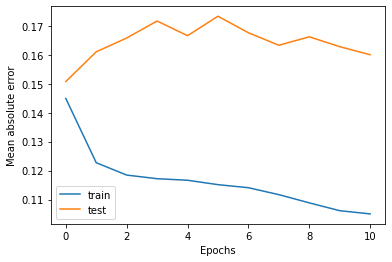

Root mean square error: 11006.736328125
MAPE: 0.2291406225500865
MAE: 7564.96230389995
R2 score: 0.36527386291844055
 
 
---------------------------------------------------
Train on 35160 samples, validate on 600 samples
Epoch 1/100
35160/35160 [==============================] - 5s 142us/sample - loss: 0.1436 - val_loss: 0.1228
Epoch 2/100
35160/35160 [==============================] - 2s 62us/sample - loss: 0.1223 - val_loss: 0.1333
Epoch 3/100
35160/35160 [==============================] - 2s 63us/sample - loss: 0.1181 - val_loss: 0.1376
Epoch 4/100
35160/35160 [==============================] - 2s 60us/sample - loss: 0.1162 - val_loss: 0.1361
Epoch 5/100
35160/35160 [==============================] - 2s 60us/sample - loss: 0.1147 - val_loss: 0.1421
Epoch 6/100
35160/35160 [==============================] - 2s 62us/sample - loss: 0.1140 - val_loss: 0.1479
Epoch 7/100
35160/35160 [==============================] - 2s 60us/sample - loss: 0.1118 - val_loss: 0.1372
Epoch 8/100
35160/3516

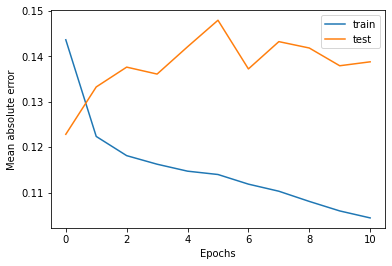

Root mean square error: 9429.8095703125
MAPE: 0.7025817692160733
MAE: 6163.05313639323
R2 score: -0.1806358236668757
 
 
---------------------------------------------------
Train on 35760 samples, validate on 620 samples
Epoch 1/100
35760/35760 [==============================] - 5s 138us/sample - loss: 0.1449 - val_loss: 0.0884
Epoch 2/100
35760/35760 [==============================] - 2s 59us/sample - loss: 0.1239 - val_loss: 0.0833
Epoch 3/100
35760/35760 [==============================] - 2s 58us/sample - loss: 0.1194 - val_loss: 0.0837
Epoch 4/100
35760/35760 [==============================] - 2s 59us/sample - loss: 0.1172 - val_loss: 0.0802
Epoch 5/100
35760/35760 [==============================] - 2s 57us/sample - loss: 0.1159 - val_loss: 0.0816
Epoch 6/100
35760/35760 [==============================] - 2s 60us/sample - loss: 0.1145 - val_loss: 0.0797
Epoch 7/100
35760/35760 [==============================] - 2s 59us/sample - loss: 0.1124 - val_loss: 0.0779
Epoch 8/100
35760/3576

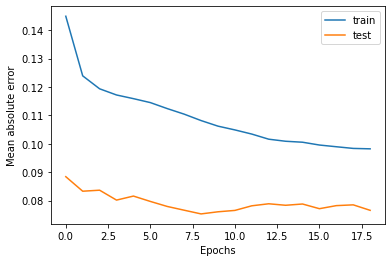

Root mean square error: 5854.46240234375
MAPE: 0.14334865492365356
MAE: 3778.870342426915
R2 score: 0.4256840095050578
 
 
---------------------------------------------------


In [26]:
# Testing
# lag=14
ds=['october','november','december']
data_LSTM_X, data_LSTM_Y = sequence_data_build(data, 7)
totday = int(data_LSTM_X.shape[0]/20)
m1 = [totday-61, totday-31, totday, ]
m2 = [m1[0]-31, m1[1]-30, m1[2]-31, ]
for i in range(len(m1)):
    trainX, trainY, testX, testY = train_test_build(data_LSTM_X, data_LSTM_Y, m1[i], m2[i])
    testYcopy=testY
    saving = True
    EarlyStop = True
    rmse, mape, mae, r2, history = model_build(trainX, trainY, testX, testY, 32, saving, ds[i], EarlyStop)
        
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.xlabel("Epochs")
    pyplot.ylabel("Mean absolute error")
    pyplot.savefig("SM3F_" + ds[i] + ".png")
    pyplot.show()
    
    
    print("Root mean square error: {0}".format(rmse))
    print("MAPE: {0}".format(mape))
    print("MAE: {0}".format(mae))
    print("R2 score: {0}".format(r2))
    print(" ")
    print(" ")
    print("---------------------------------------------------")

In [20]:
print("lag vector")
print(lag_vec)
print("LSTM units")
print(units_vec)
print("----------------------------")
print("RMSE")
print(results[0,:])

print("----------------------------")
print("MAE")
print(results[1,:])

print("----------------------------")
print("MAPE")
print(results[2,:])

print("----------------------------")
print("R2-score")
print(results[3,:])

lag vector
[7, 14]
LSTM units
[2, 4, 8, 16, 32, 64, 128]
----------------------------
RMSE
[[[5985.91162109 4749.82861328 4370.43457031 4174.17382812 4218.47705078
   3893.57202148 3996.71826172]
  [5865.63330078 4829.68261719 4406.78662109 4150.89355469 3893.29785156
   3894.04223633 3847.32983398]]

 [[6069.59326172 5535.50976562 4828.40820312 4439.98730469 4249.96337891
   4357.0234375  4317.10449219]
  [5152.12939453 4925.87695312 4467.83105469 4445.28417969 4200.15380859
   4365.25195312 4361.67773438]]

 [[7509.93115234 6428.03369141 6465.31347656 6728.41748047 6197.22705078
   5894.04052734 6287.8359375 ]
  [7705.02539062 6597.67675781 6333.01757812 5985.27294922 6577.32275391
   6475.97460938 6022.95800781]]]
----------------------------
MAE
[[[0.22139527 0.13834338 0.11626332 0.11280267 0.12330396 0.09892969
   0.10336064]
  [0.23090733 0.1289079  0.12457249 0.11528977 0.10052719 0.10414752
   0.09509252]]

 [[0.23515796 0.17776685 0.17986985 0.13008136 0.11991255 0.13197155
 

In [22]:
m1

[1751, 1781, 1812]

In [23]:
m2

[1720, 1751, 1781]